In [33]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import wordcloud
import string
import validators
import re
import string
import nltk
import langdetect
from textblob import TextBlob
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from factor_analyzer.factor_analyzer import FactorAnalyzer
import seaborn as sns
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

### All Functions

In [75]:
categories = {"is_media":["media","politics","journalism","journalist","news","reporter","blogger","youtube",\
                          "writer","youtuber","communication","radio","internet","film","television"],  
             "is_education":["educationist","teacher","professor","tutor","pedagogue","scientist","instructor", 
                             "coach","trainer","lecturer","academic","counselor","phd","educator","scholar",
                             "teaching","philosopher","consultant","physician","doctor","education","science",
                             "archaeologist","archaeology","graduate","student","advocate","lawyer","computer",
                             "philanthropist","engineer","engineering","editor","college","university","author",
                            "programming","programmer","doctorate"], 
             "is_politics":["politician","politics","senator","congress","political","archivist","legislatures",
                           "ideology","ideologist"],
             "is_art":["literature","art","artist","actor","music","dance","history","theatre","drama","producer",
                       "director","architect","actress","musician","dancer","design","photographer","storyteller",
                       "poet","decorator","improvisor","culture","humorist"],
             "is_sports":["sports","cricket","tennis","football","basketball","volleyball","cyclist"],
             "is_feminist":["feminist","feminism"]}

def add_category_columns(row):
    desc = row["user_description"]
    if desc is not np.nan:
        desc = desc.lower()
        desc = re.sub(r'[^A-Za-z]',' ',desc).strip()
        desc = re.sub('#', '', desc)                      
        desc = re.sub('https?:\/\/\S+', '', desc)  
        desc = desc.split()
        for c in categories:
            row[c] = 0
            if len(list(set(categories[c])&set(desc))) > 0:
                row[c] = 1
    return row

def get_retweet_count(user,retweet_users):
    retweet_count = 0
    if user in retweet_users:
        retweet_count = retweet_users[user]
    return retweet_count
        
def get_retweets(source_df,dest_df):
    retweet_user_list = []
    for t in source_df[source_df["is_retweet"]==1]["Text"]:
        retweet_user_list.append(t.split(" ")[1].replace("@","").replace(":",""))
    retweet_users = dict(Counter(retweet_user_list))    
    dest_df["retweet_count"] = dest_df.apply(lambda x : get_retweet_count(x["name"],retweet_users),axis=1)
    return dest_df,retweet_users

def mention_names(df,retweet_list):
    mention_screen_names = []
    for i in list(df["user_mention_screen_name"]):
        try:
            i = i.split(";")
            for x in i:
                if x not in retweet_list:
                    mention_screen_names.append(x)
        except Exception as e:
            pass
    return mention_screen_names

def mention_counts(user,mentions):
    mention_count = 0
    if user in mentions:
        mention_count = mentions[user]
    return mention_count


def get_mentions(source_df,dest_df,retweet_list):
    mentions = Counter(mention_names(source_df,retweet_list))
    dest_df["mention_count"] = dest_df.apply(lambda x : mention_counts(x["name"],mentions),axis=1)
    return dest_df

def detect_bio_lang(row):
    text = row["user_description"]
    row["bio_language"] = "NA"
    try:
        if text is not np.nan or len(text) > 2: 
            row["bio_language"] = langdetect.detect(text)
    except Exception as e:
        pass
    return row

def get_all_users(df):
    user_details = {}
    for i,j in df[["from_user","user_description"]].values:
        if i not in user_details:
            user_details[i] = j
    user_details = pd.DataFrame(user_details.items(), columns=["from_user", "user_description"])
    return user_details


def get_tweet_counts(source_df,dest_df):
    tweet_counts = source_df.groupby("from_user")["Text"].count().reset_index()
    tweet_counts.columns = ["from_user","tweets_count"]
    dest_df = pd.merge(dest_df,tweet_counts[tweet_counts["from_user"].isin(dest_df["from_user"])],how="left",on="from_user")
    return dest_df

def add_category_columns_tweets(row):
    desc = row["Text"]
    if desc is not np.nan:
        desc = desc.lower()
        desc = re.sub(r'[^A-Za-z]',' ',desc).strip()
        desc = re.sub('#', '', desc)                      
        desc = re.sub('https?:\/\/\S+', '', desc)  
        desc = desc.split()
        for c in categories:
            row[c] = 0
            if len(list(set(categories[c])&set(desc))) > 0:
                row[c] = 1
    return row

def transform_columns(df):
    df = df.drop(["created_at","from_user","user_description","movement_in","name"],axis=1)
    df["bio_language"] = df["bio_language"].fillna("NA")
    df["followers_count"] = df["followers_count"].fillna(0)
    df["tweets_count"] = df["tweets_count"].fillna(0)
    df["retweet_count"] = df["retweet_count"].fillna(0)
    df["tweets_count"] = df["tweets_count"].fillna(0)
    df["mention_count"] = df["mention_count"].fillna(0)
    df["is_art"] = df["is_art"].fillna(0)
    df["is_education"] = df["is_education"].fillna(0)
    df["is_feminist"] = df["is_feminist"].fillna(0)
    df["is_media"] = df["is_media"].fillna(0)
    df["is_politics"] = df["is_politics"].fillna(0)
    df["is_sports"] = df["is_sports"].fillna(0)
    df["positive"] = df["positive"].fillna(0)
    df["negative"] = df["negative"].fillna(0)
    df["neutral"] = df["neutral"].fillna(0)
    df["education_content_count"] = df["education_content_count"].fillna(0)
    df["media_content_count"] = df["media_content_count"].fillna(0)
    df["politics_content_count"] = df["politics_content_count"].fillna(0)
    
    lb_make = LabelEncoder()
    df["bio_language"] = lb_make.fit_transform(df["bio_language"])
    df["macro_micro"] = lb_make.fit_transform(df["macro_micro"])
    #df["name"] = lb_make.fit_transform(df["name"])
    return df

  
def calculate_vif_(X, thresh=50):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [27]:
mac_mic = glob.glob("./Data/*.csv")
i_sb = pd.DataFrame()
i_gw = pd.DataFrame()
i_wm = pd.DataFrame()
i_mc = pd.DataFrame()

for i in mac_mic:
    movement = i.split("/")[2].split(".")[0].split("_")[2]
    if movement == "sb":
        i_sb = pd.read_csv(i)
        i_sb["movement_in"] = "StopTheBan"
        print(i_sb.shape)
    elif movement == "gw":
        i_gw = pd.read_csv(i)
        i_gw["movement_in"] = "GrabYourWallet"
        print(i_gw.shape)
    elif movement == "wm":
        i_wm = pd.read_csv(i)
        i_wm["movement_in"] = "WhyIMarch"
        print(i_wm.shape)
    else:
        i_mc = pd.read_csv(i)
        i_mc["movement_in"] = "McStrike"
        print(i_mc.shape)

(10478, 4)
(3111, 4)
(11484, 4)
(27331, 4)


### Basic Cleaning

In [79]:
dataM1 = glob.glob("./Data/20170122 WhyIMarch/*.csv")
dataM2 = glob.glob("./Data/20170204 GrabYourWallet/*.csv")
dataM3 = glob.glob("./Data/20190521 StoptheBan/*.csv")
dataM4 = glob.glob("./Data/McStrike/*.csv")

M1 = pd.DataFrame()
for d in dataM1:
    M1 = pd.concat([M1,pd.read_csv(d)])

M2 = pd.DataFrame()
for d in dataM2:
    M2 = pd.concat([M2,pd.read_csv(d)])
    
M3 = pd.DataFrame()
for d in dataM3:
    M3 = pd.concat([M3,pd.read_csv(d)])
    
M4 = pd.DataFrame()
for d in dataM4:
    M4 = pd.concat([M4,pd.read_csv(d)])    
    
M1.columns = [x.replace("[M] ","").replace(": ","") for x in M1.columns] 
M2.columns = [x.replace("[M] ","").replace(": ","") for x in M2.columns] 
M3.columns = [x.replace("[M] ","").replace(": ","") for x in M3.columns] 
M4.columns = [x.replace("[M] ","").replace(": ","") for x in M4.columns] 

M1["followers_count"] = M1["followers_count"].fillna(0)
M2["followers_count"] = M2["followers_count"].fillna(0)
M3["followers_count"] = M3["followers_count"].fillna(0)

M1["favourites_count"] = M1["favourites_count"].fillna(0)
M2["favourites_count"] = M2["favourites_count"].fillna(0)
M3["favourites_count"] = M3["favourites_count"].fillna(0)

M1["friends_count"] = M1["friends_count"].fillna(0)
M2["friends_count"] = M2["friends_count"].fillna(0)
M3["friends_count"] = M3["friends_count"].fillna(0)

M1["username"] = M1["username"].fillna("NA")
M2["username"] = M2["username"].fillna("NA")
M3["username"] = M3["username"].fillna("NA")

M1["hashtag"] = M1["hashtag"].fillna("NA")
M2["hashtag"] = M2["hashtag"].fillna("NA")                                   
M3["hashtag"] = M3["hashtag"].fillna("NA")

M1["movement_name"] = "WhyIMarch"
M2["movement_name"] = "GrabYourWallet"
M3["movement_name"] = "StopTheBan"
M4["movement_name"] = "McStrike"

M1["created_at"] =  pd.to_datetime(M1["created_at"], format='%Y-%m-%d %H:%M:%S')
M2["created_at"] =  pd.to_datetime(M2["created_at"], format='%Y-%m-%d %H:%M:%S')
M3["created_at"] =  pd.to_datetime(M3["created_at"], format='%Y-%m-%d %H:%M:%S')
M4["created_at"] =  pd.to_datetime(M4["created_at"], format='%Y-%m-%d %H:%M:%S')

M1["is_retweet"] = 0
M1.loc[M1["Text"].str.contains("^RT"),"is_retweet"] = 1
M2["is_retweet"] = 0
M2.loc[M2["Text"].str.contains("^RT"),"is_retweet"] = 1
M3["is_retweet"] = 0
M3.loc[M3["Text"].str.contains("^RT"),"is_retweet"] = 1
M4["is_retweet"] = 0
M4.loc[M4["Text"].str.contains("^RT"),"is_retweet"] = 1

In [80]:
print("WhyIMarch :- ",M1.shape)
print("GrabYourWallet :- ",M2.shape)
print("StopTheBan :- ",M3.shape)
print("McStrike :- ",M4.shape)

WhyIMarch :-  (90288, 32)
GrabYourWallet :-  (42403, 34)
StopTheBan :-  (99343, 35)
McStrike :-  (597065, 35)


In [6]:
print(set(list(M2.columns)).difference(set(list(M1.columns))),\
      set(list(M3.columns)).difference(set(list(M1.columns))),\
set(list(M4.columns)).difference(set(list(M1.columns))))

{'Annotations', 'ReferenceText'} {'tweet_id', 'profile_image_url', 'statuses_count'} {'tweet_id', 'profile_image_url', 'statuses_count'}


### Get all unique users

In [95]:
M1_users = get_all_users(M1)
print("Unique users in WhyIMarch :- ",M1_users.shape)
M2_users = get_all_users(M2)
print("Unique users in GrabYourWallet :- ",M2_users.shape)
M3_users = get_all_users(M3)
print("Unique users in StopTheBan :- ",M3_users.shape)
M4_users = get_all_users(M4)
print("Unique users in McStrike :- ",M4_users.shape)

Unique users in WhyIMarch :-  (70163, 2)
Unique users in GrabYourWallet :-  (21607, 2)
Unique users in StopTheBan :-  (56583, 2)
Unique users in McStrike :-  (229369, 2)


In [96]:
print("Number of influencers_WM  :- ",len(set(i_wm["name"])))
print("Number of influencers_GW  :- ",len(set(i_gw["name"])))
print("Number of influencers_SB  :- ",len(set(i_sb["name"])))
print("Number of influencers_MC  :- ",len(set(i_mc["name"])))
print("\n")
print("Number of influencers_WM with description :- ",len(set(i_wm["name"])&(set(M1_users["from_user"]))))
print("Number of influencers_GW with description :- ",len(set(i_gw["name"])&(set(M2_users["from_user"]))))
print("Number of influencers_SB with description :- ",len(set(i_sb["name"])&(set(M3_users["from_user"]))))
print("Number of influencers_MC with description :- ",len(set(i_mc["name"])&(set(M4_users["from_user"]))))

Number of influencers_WM  :-  11484
Number of influencers_GW  :-  3111
Number of influencers_SB  :-  10478
Number of influencers_MC  :-  27331


Number of influencers_WM with description :-  10885
Number of influencers_GW with description :-  2924
Number of influencers_SB with description :-  10187
Number of influencers_MC with description :-  26302


In [202]:
10885 + 2924 + 10187 + 26302, 11484 + 3111 + 10478 + 27331

(50298, 52404)

### Take influencers data from every movement

In [97]:
M1_users = pd.merge(i_wm,M1_users,right_on="from_user",left_on="name",how="left")
M2_users = pd.merge(i_gw,M2_users,right_on="from_user",left_on="name",how="left")
M3_users = pd.merge(i_sb,M3_users,right_on="from_user",left_on="name",how="left")
M4_users = pd.merge(i_mc,M4_users,right_on="from_user",left_on="name",how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 6) (3111, 6) (10478, 6) (27331, 6)


### Get latest followers count

In [98]:
M1_users = pd.merge(M1_users,M1.loc[M1["from_user"].isin(M1_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M2_users = pd.merge(M2_users,M2.loc[M2["from_user"].isin(M2_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M3_users = pd.merge(M3_users,M3.loc[M3["from_user"].isin(M3_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
M4_users = pd.merge(M4_users,M4.loc[M4["from_user"].isin(M4_users["from_user"])].sort_values("created_at").groupby("from_user").last().reset_index()[["from_user","created_at","followers_count"]],how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 8) (3111, 8) (10478, 8) (27331, 8)


### Add category columns

In [99]:
M1_users = M1_users.apply(add_category_columns,axis=1)
M2_users = M2_users.apply(add_category_columns,axis=1)
M3_users = M3_users.apply(add_category_columns,axis=1)
M4_users = M4_users.apply(add_category_columns,axis=1)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 11) (3111, 11) (10478, 11) (27331, 11)


### Get number of times retweeted

In [137]:
M1_users,M1_retweets = get_retweets(M1,M1_users)
M2_users,M2_retweets = get_retweets(M2,M2_users)
M3_users,M3_retweets = get_retweets(M3,M3_users)
M4_users,M4_retweets = get_retweets(M4,M4_users)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 12) (3111, 12) (10478, 12) (27331, 12)


### Get number of times mentioned

In [138]:
M1_users = get_mentions(M1,M1_users,M1_retweets)
M2_users = get_mentions(M2,M2_users,M2_retweets)
M3_users = get_mentions(M3,M3_users,M3_retweets)
M4_users = get_mentions(M4,M4_users,M4_retweets)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 13) (3111, 13) (10478, 13) (27331, 13)


### Get tweets count

In [146]:
M1_users = get_tweet_counts(M1,M1_users)
M2_users = get_tweet_counts(M2,M2_users)
M3_users = get_tweet_counts(M3,M3_users)
M4_users = get_tweet_counts(M4,M4_users)
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 14) (3111, 14) (10478, 14) (27331, 14)


In [147]:
M1_users.to_csv("./M1_users.csv",index=False)
M2_users.to_csv("./M2_users.csv",index=False)
M3_users.to_csv("./M3_users.csv",index=False)
M4_users.to_csv("./M4_users.csv",index=False)

### Get bio language

In [149]:
%time M1_users = M1_users.apply(detect_bio_lang,axis=1)

CPU times: user 8min 17s, sys: 2.72 s, total: 8min 20s
Wall time: 8min 19s


In [150]:
%time M2_users = M2_users.apply(detect_bio_lang,axis=1)

CPU times: user 1min 49s, sys: 624 ms, total: 1min 50s
Wall time: 1min 50s


In [151]:
%time M3_users = M3_users.apply(detect_bio_lang,axis=1)

CPU times: user 6min 51s, sys: 2.35 s, total: 6min 53s
Wall time: 6min 53s


In [152]:
%time M4_users = M4_users.apply(detect_bio_lang,axis=1)

CPU times: user 17min 50s, sys: 6.8 s, total: 17min 57s
Wall time: 17min 57s


In [154]:
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 15) (3111, 15) (10478, 15) (27331, 15)


In [9]:
def cleanText(text):
    if len(text) > 2 or text is not np.nan:
        text = re.sub('RT[\s]+', '', text)                # Removing RT
        text = re.sub('@[A-Za-z0–9]+', '', text)          # Removing @mentions
        text = re.sub('#', '', text)                      # Removing '#' hash tag
        text = re.sub('https?:\/\/\S+', '', text)         # Removing hyperlink
        for i in text:
            if i not in string.printable[0:62]:
                text = text.replace(i," ")
    return text

In [46]:
def get_tweet_sentiment(tweet):
    try:
        analysis = TextBlob(cleanText(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
    except Exception as e:
        print(e)
        return "NA"


In [47]:
sample = shuffle(M1).head()

In [48]:
%time M1["tweet_sentiment"] = M1.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 33.3 s, sys: 94.2 ms, total: 33.4 s
Wall time: 33.4 s


In [49]:
%time M2["tweet_sentiment"] = M2.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 16.9 s, sys: 9.08 ms, total: 16.9 s
Wall time: 16.9 s


In [50]:
%time M3["tweet_sentiment"] = M3.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 43 s, sys: 8.71 ms, total: 43 s
Wall time: 43 s


In [51]:
%time M4["tweet_sentiment"] = M4.apply(lambda s : get_tweet_sentiment(s["Text"]),axis = 1)

CPU times: user 4min 11s, sys: 329 ms, total: 4min 11s
Wall time: 4min 11s


In [52]:
print(M1["tweet_sentiment"].value_counts())
print(M2["tweet_sentiment"].value_counts())
print(M3["tweet_sentiment"].value_counts())
print(M4["tweet_sentiment"].value_counts())

neutral     50146
positive    27706
negative    12436
Name: tweet_sentiment, dtype: int64
neutral     25800
positive    13107
negative     3496
Name: tweet_sentiment, dtype: int64
positive    43820
neutral     42070
negative    13453
Name: tweet_sentiment, dtype: int64
neutral     313824
positive    209872
negative     73369
Name: tweet_sentiment, dtype: int64


In [62]:
M1_sentiment = pd.pivot_table(M1[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M2_sentiment = pd.pivot_table(M2[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M3_sentiment = pd.pivot_table(M3[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)
M4_sentiment = pd.pivot_table(M4[["from_user","tweet_sentiment"]],index = "from_user", columns = "tweet_sentiment", aggfunc=len).fillna(0)

In [65]:
M1_users = pd.merge(M1_users,M1_sentiment,left_on="from_user",right_on="from_user",how="left")
M2_users = pd.merge(M2_users,M2_sentiment,left_on="from_user",right_on="from_user",how="left")
M3_users = pd.merge(M3_users,M3_sentiment,left_on="from_user",right_on="from_user",how="left")
M4_users = pd.merge(M4_users,M4_sentiment,left_on="from_user",right_on="from_user",how="left")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

(11484, 18) (3111, 18) (10478, 18) (27331, 18)


In [120]:
M1_users.columns

Index(['bio_language', 'community', 'created_at', 'followers_count',
       'from_user', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count',
       'movement_in', 'name', 'negative', 'neutral', 'positive',
       'retweet_count', 'tweets_count', 'user_description'],
      dtype='object')

### Tweet content count

In [84]:
%time M1 = M1.apply(add_category_columns_tweets,axis=1)

CPU times: user 19.3 s, sys: 136 ms, total: 19.4 s
Wall time: 19.4 s


In [85]:
%time M2 = M2.apply(add_category_columns_tweets,axis=1)

CPU times: user 9.82 s, sys: 43.9 ms, total: 9.87 s
Wall time: 9.87 s


In [86]:
%time M3 = M3.apply(add_category_columns_tweets,axis=1)

CPU times: user 21.8 s, sys: 120 ms, total: 21.9 s
Wall time: 21.9 s


In [87]:
%time M4 = M4.apply(add_category_columns_tweets,axis=1)
print(M1.shape,M2.shape,M3.shape,M4.shape)

CPU times: user 46min 14s, sys: 4.61 s, total: 46min 18s
Wall time: 46min 19s
(90288, 38) (42403, 40) (99343, 41) (597065, 41)


In [134]:
tweet_content_M1 = pd.DataFrame(M1[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M1 = tweet_content_M1.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M2 = pd.DataFrame(M2[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M2 = tweet_content_M2.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M3 = pd.DataFrame(M3[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M3 = tweet_content_M3.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})
tweet_content_M4 = pd.DataFrame(M4[["from_user","is_education","is_media","is_politics"]].groupby("from_user").sum().reset_index())
tweet_content_M4 = tweet_content_M4.rename(columns={"is_education": "education_content_count", "is_media": "media_content_count","is_politics":"politics_content_count"})

M1_users = pd.merge(tweet_content_M1,M1_users,left_on="from_user",right_on="from_user",how="right")
M2_users = pd.merge(tweet_content_M2,M2_users,left_on="from_user",right_on="from_user",how="right")
M3_users = pd.merge(tweet_content_M3,M3_users,left_on="from_user",right_on="from_user",how="right")
M4_users = pd.merge(tweet_content_M4,M4_users,left_on="from_user",right_on="from_user",how="right")
print(M1_users.shape,M2_users.shape,M3_users.shape,M4_users.shape)

In [ ]:
sns.heatmap(M1_users.corr())

In [ ]:
sns.heatmap(M2_users.corr())

In [ ]:
sns.heatmap(M3_users.corr())

In [ ]:
sns.heatmap(M4_users.corr())

In [ ]:
M1_users.groupby(['macro_micro','is_education']).size().reset_index().pivot_table(columns='is_education', index='macro_micro', values=0).plot(kind = 'bar',stacked = True),

In [ ]:
M1_users.groupby(['macro_micro','is_education','is_media','is_politics','is_art','is_sports','is_feminist']).size().reset_index()

In [72]:
M1_users.columns

Index(['from_user', 'education_content_count', 'media_content_count',
       'politics_content_count', 'bio_language', 'community', 'created_at',
       'followers_count', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count',
       'movement_in', 'name', 'negative', 'neutral', 'positive',
       'retweet_count', 'tweets_count', 'user_description'],
      dtype='object')

In [76]:
M1_final_users = transform_columns(M1_users)
M2_final_users = transform_columns(M1_users)
M3_final_users = transform_columns(M3_users)
M4_final_users = transform_columns(M4_users)

In [77]:
M1_f = calculate_vif_(M1_final_users)
M2_f = calculate_vif_(M2_final_users)
M3_f = calculate_vif_(M3_final_users)
M4_f = calculate_vif_(M4_final_users)

dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',
       'politics_content_count', 'bio_language', 'community',
       'followers_count', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count', 'neutral',
       'positive', 'retweet_count'],
      dtype='object')
dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',
       'politics_content_count', 'bio_language', 'community',
       'followers_count', 'is_art', 'is_education', 'is_feminist', 'is_media',
       'is_politics', 'is_sports', 'macro_micro', 'mention_count', 'neutral',
       'positive', 'retweet_count'],
      dtype='object')
dropping 'negative' at index: 14
dropping 'tweets_count' at index: 17
Remaining variables:
Index(['education_content_count', 'media_content_count',


In [78]:
# Bartlett’s test of sphericity checks whether or not the observed variables 
# intercorrelate at all using the observed correlation matrix against the identity matrix. 
# If the test found statistically insignificant, you should not employ a factor analysis.
from factor_analyzer import factor_analyzer

chi_square_value_M1,p_value_M1 = factor_analyzer.calculate_bartlett_sphericity(M1_f)
print(chi_square_value_M1,p_value_M1)
chi_square_value_M2,p_value_M2 = factor_analyzer.calculate_bartlett_sphericity(M2_f)
print(chi_square_value_M2,p_value_M2)
chi_square_value_M3,p_value_M3 = factor_analyzer.calculate_bartlett_sphericity(M3_f)
print(chi_square_value_M3,p_value_M3)
chi_square_value_M4,p_value_M4 = factor_analyzer.calculate_bartlett_sphericity(M4_f)
print(chi_square_value_M4,p_value_M4)

42124.942231949535 0.0
42124.942231949535 0.0
24535.493186265394 0.0
100899.73664962902 0.0


In [79]:
# Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. 
# It determines the adequacy for each observed variable and for the complete model. 
# KMO estimates the proportion of variance among all the observed variable. 
# Lower proportion id more suitable for factor analysis. 
# KMO values range between 0 and 1. 
# Value of KMO less than 0.6 is considered inadequate.

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all_M1,kmo_model_M1 = calculate_kmo(M1_f)
print(kmo_model_M1)
kmo_all_M2,kmo_model_M2 = calculate_kmo(M2_f)
print(kmo_model_M2)
kmo_all_M3,kmo_model_M3 = calculate_kmo(M3_f)
print(kmo_model_M3)
kmo_all_M4,kmo_model_M4 = calculate_kmo(M4_f)
print(kmo_model_M4)

0.6740137792926608
0.6740137792926608
0.6817274547081452
0.62956003657593


In [82]:
def factor_analysis(df):
    # Create factor analysis object and perform factor analysis
    # Kaiser test choose features with eigenvalues greater than 1
    fa = FactorAnalyzer()
    fa.fit(df)
    eigen_values, vectors = fa.get_eigenvalues()
    plt.scatter(range(1,df.shape[1]+1),eigen_values)
    plt.plot(range(1,df.shape[1]+1),eigen_values)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    
    fa = FactorAnalyzer()
    fa.set_params(n_factors = 4, rotation = "varimax")
    fa.fit(df)
    loadings = fa.loadings_
    print(fa.get_factor_variance())
    return pd.DataFrame(loadings)

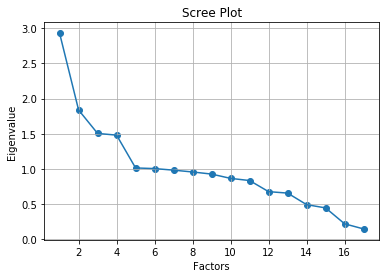

(array([2.550825  , 1.55612251, 1.25095126, 0.80556493]), array([0.15004853, 0.09153662, 0.07358537, 0.04738617]), array([0.15004853, 0.24158515, 0.31517052, 0.36255669]))
           0         1         2         3
0   0.476301  0.030898  0.000802  0.031291
1   0.649011 -0.011698  0.001111  0.029661
2   0.429552  0.006222  0.001537  0.031000
3   0.007273 -0.106739 -0.015584  0.073587
4   0.054000  0.952001 -0.011555  0.114967
5   0.001799  0.010840  0.505295 -0.004755
6   0.013021  0.012469  0.002894  0.293650
7   0.026117  0.044158  0.003921  0.292491
8   0.004322  0.003533 -0.002467  0.158262
9   0.014092 -0.016961  0.003943  0.626874
10  0.007007  0.005979  0.002175  0.404455
11 -0.002229 -0.015798 -0.004282  0.119438
12  0.075125  0.795754 -0.009111  0.127713
13  0.034019  0.025992 -0.000251 -0.001694
14  0.957966  0.012918  0.001750 -0.007229
15  0.888614  0.016701  0.000055  0.008430
16  0.001602  0.011768  0.997544 -0.002228


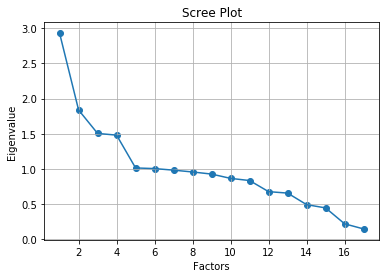

(array([2.550825  , 1.55612251, 1.25095126, 0.80556493]), array([0.15004853, 0.09153662, 0.07358537, 0.04738617]), array([0.15004853, 0.24158515, 0.31517052, 0.36255669]))
           0         1         2         3
0   0.476301  0.030898  0.000802  0.031291
1   0.649011 -0.011698  0.001111  0.029661
2   0.429552  0.006222  0.001537  0.031000
3   0.007273 -0.106739 -0.015584  0.073587
4   0.054000  0.952001 -0.011555  0.114967
5   0.001799  0.010840  0.505295 -0.004755
6   0.013021  0.012469  0.002894  0.293650
7   0.026117  0.044158  0.003921  0.292491
8   0.004322  0.003533 -0.002467  0.158262
9   0.014092 -0.016961  0.003943  0.626874
10  0.007007  0.005979  0.002175  0.404455
11 -0.002229 -0.015798 -0.004282  0.119438
12  0.075125  0.795754 -0.009111  0.127713
13  0.034019  0.025992 -0.000251 -0.001694
14  0.957966  0.012918  0.001750 -0.007229
15  0.888614  0.016701  0.000055  0.008430
16  0.001602  0.011768  0.997544 -0.002228


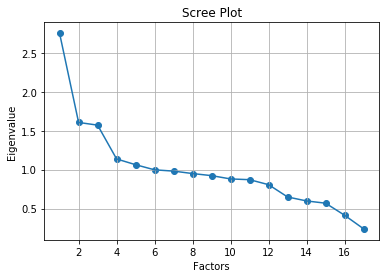

(array([2.32820143, 1.31875641, 0.92769309, 0.43254249]), array([0.13695303, 0.07757391, 0.05457018, 0.02544368]), array([0.13695303, 0.21452693, 0.26909711, 0.29454079]))
           0         1         2         3
0   0.513639  0.037870  0.063497 -0.257376
1   0.519819  0.112688  0.077062 -0.525948
2   0.486103 -0.012309  0.008956  0.028278
3   0.016860 -0.026306  0.134871  0.012838
4   0.020777  0.984955  0.018067  0.158703
5   0.022155  0.025553  0.030341  0.063437
6  -0.014516 -0.001700  0.258117  0.020102
7   0.007686 -0.007784  0.209359  0.008321
8   0.057000  0.009455  0.069366  0.002513
9  -0.000959  0.002826  0.723785  0.063377
10  0.032974  0.006940  0.492136  0.070753
11 -0.014751  0.033840  0.125671  0.035494
12 -0.033191  0.574749 -0.025215  0.029969
13  0.004778  0.003335  0.006956  0.015851
14  0.803816 -0.019901  0.016400  0.062996
15  0.916914 -0.023580 -0.009621  0.184369
16  0.252708 -0.018329 -0.006092  0.098141


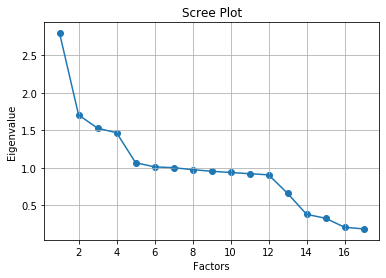

(array([2.15462334, 1.67000609, 1.4503803 , 0.83594897]), array([0.12674255, 0.09823565, 0.08531649, 0.04917347]), array([0.12674255, 0.2249782 , 0.31029469, 0.35946816]))
           0         1         2         3
0   0.744555  0.025268 -0.012685 -0.006887
1   0.281547  0.795826  0.007112 -0.011534
2   0.019637  0.977318  0.002078 -0.004406
3   0.010819 -0.000244  0.119296  0.045119
4   0.009363  0.006847  0.672598  0.003634
5   0.004827 -0.001406  0.028337  0.073872
6   0.002531  0.000563  0.001723  0.262451
7   0.015696 -0.007280 -0.007999  0.217880
8   0.015605 -0.004107  0.001953  0.101002
9   0.019928  0.026248  0.056002  0.697503
10  0.009354  0.004256  0.001233  0.423158
11 -0.003592 -0.000852 -0.005484  0.124596
12 -0.001711  0.002860  0.988800 -0.134821
13  0.019569 -0.000319  0.006687  0.010066
14  0.810600  0.256185  0.010648 -0.045561
15  0.917605  0.120050 -0.040260 -0.012164
16  0.141164  0.000926  0.000682  0.009503


In [83]:
M1_loadings = factor_analysis(M1_f)
print(M1_loadings)
M2_loadings = factor_analysis(M2_f)
print(M2_loadings)
M3_loadings = factor_analysis(M3_f)
print(M3_loadings)
M4_loadings = factor_analysis(M4_f)
print(M4_loadings)

In [66]:
M1_users = pd.read_csv("./M1_users.csv")
M2_users = pd.read_csv("./M2_users.csv")
M3_users = pd.read_csv("./M3_users.csv")
M4_users = pd.read_csv("./M4_users.csv")

In [33]:
# Recovery code
M1_final_users = pd.read_csv("./M1_f.csv")
M2_final_users = pd.read_csv("./M2_f.csv")
M3_final_users = pd.read_csv("./M3_f.csv")
M4_final_users = pd.read_csv("./M4_f.csv")

In [161]:
M1_users.to_csv("./M1_users.csv",index=False)
M2_users.to_csv("./M2_users.csv",index=False)
M3_users.to_csv("./M3_users.csv",index=False)
M4_users.to_csv("./M4_users.csv",index=False)

In [159]:
M1_final_users.to_csv("./M1_f.csv",index=False)
M2_final_users.to_csv("./M2_f.csv",index=False)
M3_final_users.to_csv("./M3_f.csv",index=False)
M4_final_users.to_csv("./M4_f.csv",index=False)